In [51]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [52]:
df = pd.read_csv('shrees_attachments/20210109_dft_ml_redox_data.csv.gz', index_col=0)
df.head()

,ionization energy,electron affinity,pred ionization energy,pred electron affinity,err ionization energy,err electron affinity
smiles,,,,,,
C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,1.001039,NaN,0.944633,-0.206506,0.056406,NaN
C=C(O)C(=S)C1=C([CH]O)C(=O)CCC1=O,0.348169,0.325529,1.196336,-0.039882,0.848167,0.365411
C=C(CCO)C1=C([O])CCC=C1CCC,0.964468,-0.281083,1.045361,-0.254922,0.080893,0.026161
CCC=C(CN)C(CC)=C([O])C(C)(C)C,0.350509,-0.457001,0.886134,-0.435990,0.535625,0.021011
C=C(CCO)C([O])=C(C(C)C)C(C)(C)C,NaN,-0.221001,1.173760,-0.257057,NaN,0.036056


In [13]:
df.shape

(3762, 6)

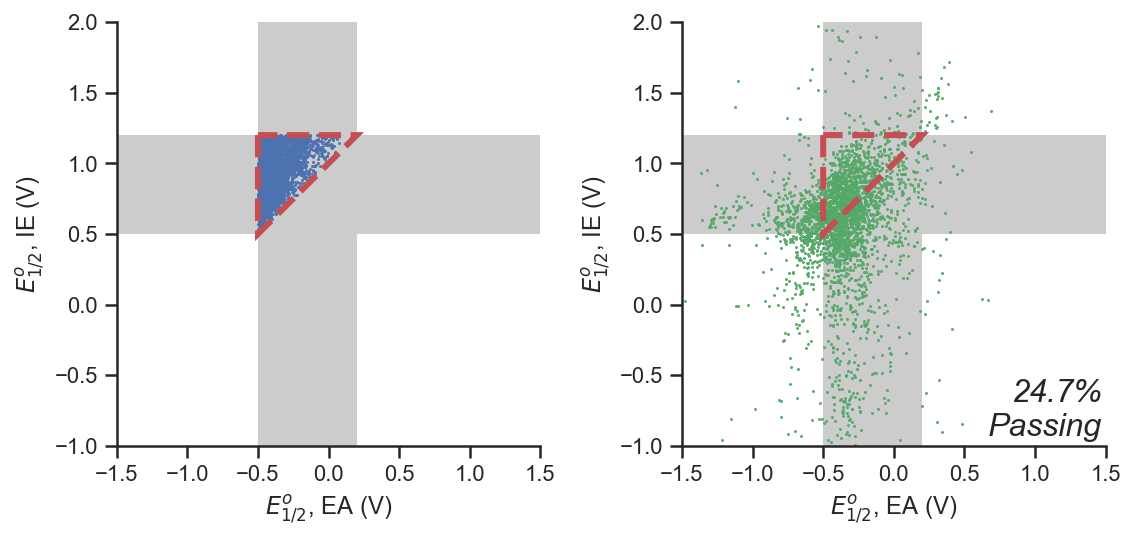

In [14]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, aspect='equal')

ax1.plot(df['pred electron affinity'], df['pred ionization energy'], '.', ms=1, rasterized=True)
ax1.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-1, 2])

ax1.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax1.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax1.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax1.set_ylabel(r'$E_{1/2}^o$, IE (V)')

ax2 = fig.add_subplot(122, aspect='equal')
ax2.plot(df['electron affinity'], df['ionization energy'], '.', ms=1, color='g', rasterized=True)
ax2.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax2.set_xlim([-1.5, 1.5])
ax2.set_ylim([-1, 2])

ax2.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax2.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax2.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax2.set_ylabel(r'$E_{1/2}^o$, IE (V)')

df['V_diff'] = df['ionization energy'] - df['electron affinity']
df_pass = df[(df['electron affinity'] > -.5) &
        (df['ionization energy'] < 1.2) &
        (df['V_diff'] > 1)]

ax2.text(.99, .01, f'{df_pass.shape[0] / df.shape[0]:.1%}\nPassing', ha='right', va='bottom', transform=ax2.transAxes, fontsize='16', style='italic')

sns.despine()
plt.tight_layout()
# plt.savefig('redox_dft_confirmation.svg')

In [15]:
df_pass.shape[0] / df.dropna(subset=['V_diff']).shape[0]

0.311892797319933

In [16]:
df_spin = pd.read_csv('20210109_dft_ml_spin_bv_data.csv.gz')

In [17]:
df_spin.head()

,buried_vol,pred buried_vol,fractional_spin,pred fractional_spin,smiles,atom_index
0,40.057887,37.746520,0.085155,0.130998,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,0
1,54.431655,53.257458,0.024316,0.055328,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,1
2,41.549793,40.567318,0.009385,0.004386,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,2
3,32.768445,32.566360,0.001184,0.002064,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,3
4,62.511166,63.582790,0.345404,0.263097,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,4


In [18]:
import rdkit
import rdkit.Chem

In [19]:
def get_atom_symbols():
    for smiles in df_spin.smiles.unique():
        mol = rdkit.Chem.MolFromSmiles(smiles)
        for i, atom in enumerate(mol.GetAtoms()):
            yield pd.Series({
                'smiles': smiles,
                'atom_index': i,
                'atom_symbol': atom.GetSymbol()})

In [20]:
atom_symbol_df = pd.DataFrame(get_atom_symbols())

In [21]:
df_spin_symbol = df_spin.merge(atom_symbol_df, on=['smiles', 'atom_index'])

In [22]:
(df_spin_symbol.groupby('smiles').fractional_spin.idxmax() == df_spin_symbol.groupby('smiles')['pred fractional_spin'].idxmax()).mean()

0.8367491166077738

In [23]:
bur_vol_dft = df_spin_symbol.groupby('smiles').apply(lambda x: x.loc[x.fractional_spin.idxmax()].buried_vol)
bur_vol_ml = df_spin_symbol.groupby('smiles').apply(lambda x: x.loc[x['pred fractional_spin'].idxmax()][' pred buried_vol'])

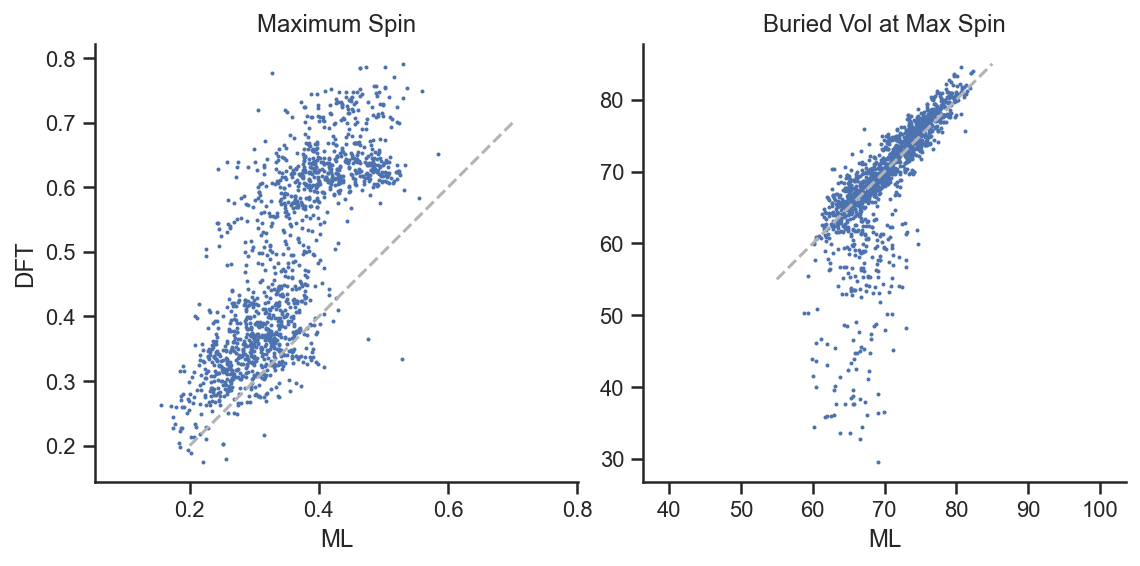

In [24]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, aspect='equal', adjustable='datalim')

ax1.plot(
    df_spin_symbol.groupby('smiles')['pred fractional_spin'].max(),
    df_spin_symbol.groupby('smiles').fractional_spin.max(),
    '.', ms=2)

ax1.plot([.2, .7], [.2, .7], '--', color='.7')

ax2 = fig.add_subplot(122, aspect='equal', adjustable='datalim')
ax2.plot(bur_vol_ml, bur_vol_dft, '.', ms=2)

ax2.plot([55, 85], [55, 85], '--', color='.7')
ax1.set_ylabel('DFT')
ax1.set_xlabel('ML')
ax2.set_xlabel('ML')

ax1.set_title('Maximum Spin')
ax2.set_title('Buried Vol at Max Spin')


sns.despine()
plt.tight_layout()

In [28]:
def stability_score(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    
    score_dft = bur_vol + 50 * (1 - spin)
    
    idxmax = x['pred fractional_spin'].idxmax()
    spin = x['pred fractional_spin'].max()
    bur_vol = x.loc[idxmax][' pred buried_vol']
    
    score_pred = bur_vol + 50 * (1 - spin)
    return pd.Series({'dft': score_dft, 'pred': score_pred})

stability_scores = df_spin_symbol.groupby('smiles').apply(stability_score)

In [29]:
redox_data = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')

In [30]:
redf_baseline = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/20210118_bde_baseline_spin_burvol.csv.gz')

def stability_score(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    return bur_vol + 50 * (1 - spin)

bde_db_stability_scores = redf_baseline.groupby('smiles').apply(stability_score)

In [31]:
sns.__version__

'0.11.1'

<AxesSubplot:xlabel='electron affinity', ylabel='ionization energy'>

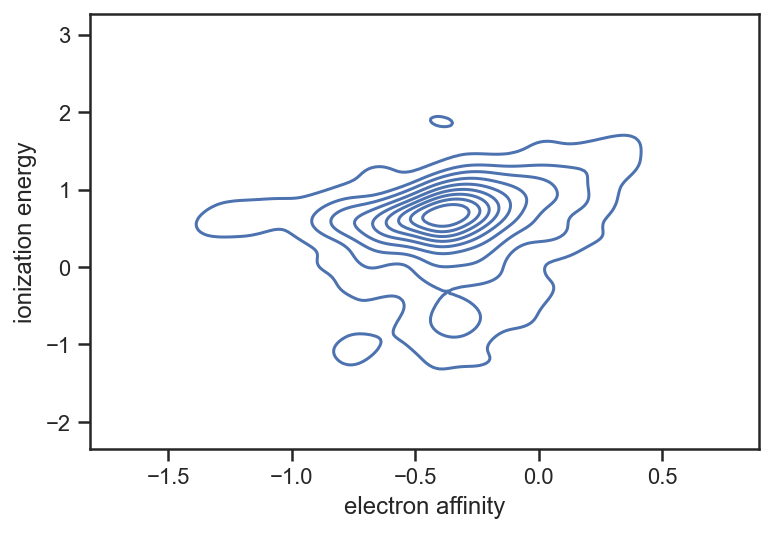

In [32]:
df_nona = df.dropna(subset=['ionization energy', 'electron affinity'])[['ionization energy', 'electron affinity']]
sns.kdeplot(data=df_nona, x='electron affinity', y='ionization energy')

In [47]:
# fig = plt.figure(dpi=150)
# ax = fig.add_subplot(aspect='equal')

# plt.hexbin(df_nona['electron affinity'], df_nona['ionization energy'], gridsize=(15, 10), cmap='Blues', vmin=0)

(0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

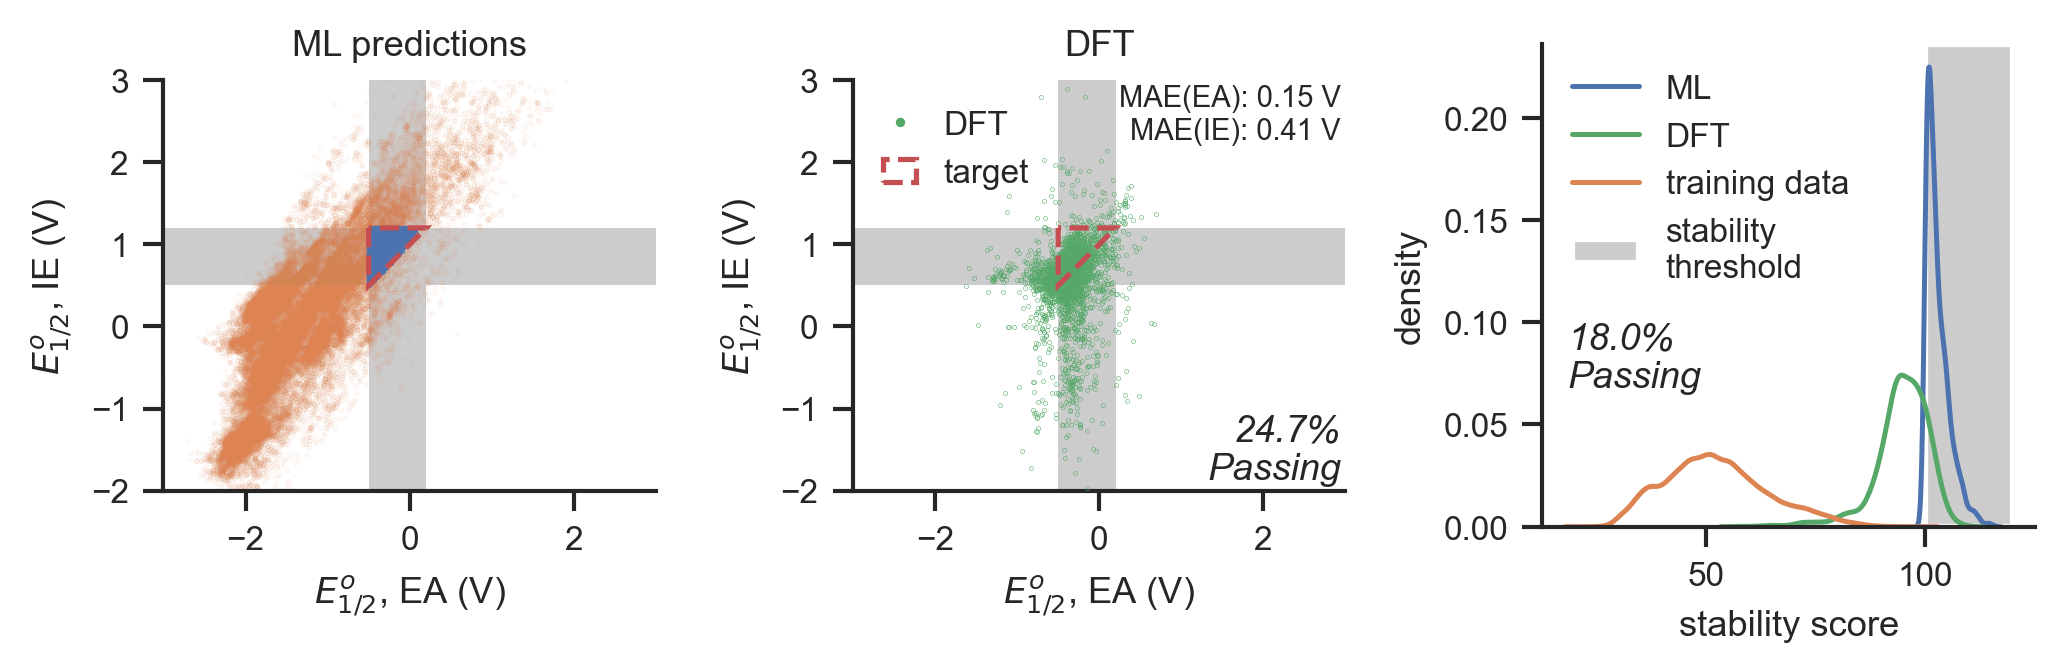

In [112]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(7,2.3), dpi=150)
ax1 = fig.add_subplot(131, aspect='equal')

ax1.plot(df['pred electron affinity'], df['pred ionization energy'], '.', ms=.5, rasterized=True, color='b', zorder=3)
ax1.plot(redox_data['electron affinity'], redox_data['ionization energy'], '.', ms=.5, rasterized=True, alpha=.1, color=sns.color_palette()[1], zorder=1)

ax1.set_xlim([-3, 3])
ax1.set_ylim([-2, 3])

ax1.axvspan(-.5, .2, facecolor='.8', edgecolor='none', zorder=0, label='allowable range')
ax1.axhspan(.5, 1.2, facecolor='.8', edgecolor='none', zorder=0)

ax1.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax1.set_ylabel(r'$E_{1/2}^o$, IE (V)')

ax2 = fig.add_subplot(132, aspect='equal', sharex=ax1, sharey=ax1)

df_nona = df.dropna(subset=['ionization energy', 'electron affinity'])
ax2.plot(df['electron affinity'], df['ionization energy'], '.', ms=.25, color='g', rasterized=True, zorder=3, label='DFT')

ax2.axvspan(-.5, .2, facecolor='.8', edgecolor='none', zorder=0)
ax2.axhspan(.5, 1.2, facecolor='.8', edgecolor='none', zorder=0)

ax2.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax2.set_ylabel(r'$E_{1/2}^o$, IE (V)')


ax1.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=1.25, ls='--'))
ax2.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=1.25, ls='--', label='target'))

df['V_diff'] = df['ionization energy'] - df['electron affinity']
df['pass_redox'] = ((df['electron affinity'] > -.5) &
                    (df['ionization energy'] < 1.2) &
                    (df['V_diff'] > 1))

df_pass = df[df.pass_redox]

df_with_stability = df.merge(stability_scores, left_on='smiles', right_index=True)

ax2.text(.99, .01, f'{df_pass.shape[0] / df.shape[0]:.1%}\nPassing', ha='right', va='bottom', transform=ax2.transAxes, fontsize='9', style='italic')


ax2.text(.99, .99, f"MAE(EA): {(df['pred electron affinity'] - df['electron affinity']).abs().mean():.2f} V\n"
         f"MAE(IE): {(df['pred ionization energy'] - df['ionization energy']).abs().mean():.2f} V",
         ha='right', va='top', fontsize='7', transform=ax2.transAxes, )
# ax2.text(.99, .99, f", ha='right', va='top', fontsize='7', transform=ax2.transAxes, )

ax2.legend(loc='upper left', handlelength=1, markerscale=10)


ax3 = fig.add_subplot(133)
sns.kdeplot(stability_scores['pred'], color='b', label='ML')
sns.kdeplot(stability_scores['dft'], color='g', label='DFT')
sns.kdeplot(bde_db_stability_scores, color=sns.color_palette()[1], label='training data')

# ax3.axvline(100, ls='--', color='r', lw=1.5)
ax3.axvspan(100, 120, facecolor='.8', lw=1.5, label='stability\nthreshold')

ax3.legend(loc='upper left')


ax3.text(.05, .35, f"{(stability_scores['dft'] > 100).mean():.1%}\nPassing",
         ha='left', va='center', transform=ax3.transAxes, fontsize='9', style='italic')

plt.ylabel('density')
plt.xlabel('stability score')

ax1.set_title('ML predictions')
ax2.set_title('DFT')

sns.despine()
plt.tight_layout()
# plt.savefig('redox_dft_confirmation.svg')

In [171]:
(df_with_stability[df_with_stability['pass_redox'] & (df_with_stability.dft > 100)]).shape[0] / df_with_stability.shape[0]

0.04890148830616584

In [188]:
df_confirmed = df_with_stability[df_with_stability['pass_redox'] & (df_with_stability.dft > 100)]

In [191]:
df_confirmed.to_csv('dft_confirmed.csv', index=False)